# Project Report

## Sentiment Analysis for Financial News And Tweets 

The question that interests us is:

Can sentiment analysis of financial news articles and social media posts be used to predict stock price movements?

### Author: **[Ajay Sah](https://github.com/aajusah98/)**



## 1. Introduction

This project aims to leverage sentiment analysis techniques to analyze financial news articles and social media posts for their impact on stock price movements. By employing Natural Language Processing (NLP) and machine learning algorithms, we aim to determine if sentiment scores from textual data can be used as a predictive signal for trading decisions. This research has the potential to provide valuable insights for investors and traders.

## 2. Data Source

### Datasource1: Financial News Dataset

- Metadata URL: [Link to metadata](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)
- Data URL: [Link to dataset](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)
- Data Type: CSV

Short description:

This dataset contains financial news articles labeled with their sentiment (positive, negative, neutral) with respect to the stock market. It will be used to train and test the sentiment analysis model.

### Datasource2: Twitter Sentiment Analysis Dataset

- Metadata URL: [Link to metadata](https://www.kaggle.com/kazanova/sentiment140)
- Data URL: [Link to dataset](https://www.kaggle.com/kazanova/sentiment140)
- Data Type: CSV

Short description:

While not specifically focused on finance, this dataset contains 1.6 million tweets labeled with sentiments (positive or negative). We will filter tweets related to stock market discussions to supplement the sentiment analysis.

The above data sets are taken from kaggle.
    


## 3. Steps Followed For Data Pipeline

1. **Import Libraries**
    Import required libraries like pandas, sqlite3, os, nltk, re, string, and KaggleApi.

2. **Define Function to Download and Extract Kaggle Dataset**
    `download_and_extract_kaggle_dataset`:This function uses Kaggle API to download a dataset, extract its files, and rename CSV files in a specified folder.

3. **Define Text Cleaning Functions**
    - `remove_html_tags`: Removes HTML tags from text.
    - `remove_url`: Removes URLs from text.
    - `handle_emoji`: Replaces emojis in text with a placeholder.
    - `remove_punc`: Removes punctuation from text.

4. **Define Function to Fetch and Clean Financial News Dataset**
-`fetch_and_clean_financial_news`:This function performs the following steps for the Financial News dataset:
    - Renames columns.
    - Converts text to lowercase.
    - Removes punctuation, numbers, newline characters, URLs, HTML tags, and handles emojis.
    - Maps sentiment labels to integers.
    - Removes stopwords.
    - Stores the cleaned data in an SQLite database.

5. **Define Function to Fetch and Clean Twitter Sentiment Dataset**
-`fetch_and_clean_twitter_sentiment`:This function performs the following steps for the Twitter Sentiment dataset:
    - Renames columns and selects relevant columns.
    - Replaces target values.
    - Converts text to lowercase.
    - Removes punctuation, numbers, URLs, HTML tags, and handles emojis.
    - Removes stopwords.
    - Stores the cleaned data in an SQLite database.

6. **Main Function**
    Creates a data directory if it doesn't exist and executes the data fetching and cleaning functions for both Financial News and Twitter Sentiment datasets.


## 4. Install dependencies

Following dependecies were installed as a requirement of the project.

In [9]:
%pip install kaggle==1.5.16 
%pip install nltk==3.8.1 
%pip install numpy==1.26.2 
%pip install pandas==2.1.3 
%pip install regex==2023.10.3 
%pip install requests==2.31.0 
%pip install pytest==7.4.3



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##  5. Load data and Import Dependencies

In [44]:
# Import Dependencies

import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from yellowbrick.classifier import ClassificationReport
from sklearn.naive_bayes import MultinomialNB

In [21]:
# Run datapipeline to create database if it doesn't exist
subprocess.run(["./pipeline.sh"])

[nltk_data] Downloading package stopwords to /home/aj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Database Created And stored at /data/financial_news.sqlite
Database Created And stored at /data/twitter_sentiment.sqlite
Pipeline completed successfully.


CompletedProcess(args=['./pipeline.sh'], returncode=0)

### Retrieve Data from Database ###

In [23]:
# Load cleaned data of finacial news from SQLite
conn = sqlite3.connect('./data/financial_news.sqlite')
financial_news_df = pd.read_sql_query("SELECT * FROM financial_news", conn)
conn.close()

# Load cleaned data of twitter sentiment from SQLite
conn = sqlite3.connect('./data/twitter_sentiment.sqlite')
twitter_sentiment_df = pd.read_sql_query("SELECT * FROM twitter_sentiment", conn)
conn.close()


## 6. Exploratory Data Analysis ##

In [61]:
# print both data frame 
print(financial_news_df.head(10))
print('\n\n')
print(twitter_sentiment_df.tail(10))

   Sentiment                                           Sentence
0          2  technopolis plans develop stages area less 100...
1          0  international electronic industry company elco...
2          1  new production plant company would increase ca...
3          1  according company updated strategy years 20092...
4          1  financing aspocomp growth aspocomp aggressivel...
5          1  last quarter 2010 componenta net sales doubled...
6          1  third quarter 2010 net sales increased 52 eur ...
7          1  operating profit rose eur 131 mn eur 87 mn cor...
8          1  operating profit totalled eur 211 mn eur 186 m...
9          1  teliasonera tlsn said offer line strategy incr...



                                                      text  target
1599989                                   wooooo xbox back       1
1599990  rmedina latati mmmm sounds absolutely perfect ...       1
1599991                            recovering long weekend       1
1599992                  

In [56]:
# list out columns
print(f"financial_news Columns: {financial_news_df.columns}")
print(f"twitter_sentiment Columns: {twitter_sentiment_df.columns}")

financial_news Columns: Index(['Sentiment', 'Sentence'], dtype='object')
twitter_sentiment Columns: Index(['text', 'target'], dtype='object')


In [29]:
# Display the shape of the DataFrame
print("Number of rows in financial news Data:", financial_news_df.shape[0])
print("Number of columns in financial news Data:", financial_news_df.shape[1])
print("Number of rows in twitter sentiment Data:", twitter_sentiment_df.shape[0])
print("Number of columns in twitter sentiment Data:", twitter_sentiment_df.shape[1])

Number of rows in financial news Data: 4845
Number of columns in financial news Data: 2
Number of rows in twitter sentiment Data: 1599999
Number of columns in twitter sentiment Data: 2


In [30]:
# Split the data into features (X) and target (y) for financial_news_df and twitter_sentiment_df
feature_for_finance = financial_news_df['Sentence']
target_for_finance = financial_news_df['Sentiment']

feature_for_twitter_sentiment = twitter_sentiment_df['text']
target_for_twitter_sentiment = twitter_sentiment_df['target']

In [31]:
# Split the data into training and testing sets for financial_news_df and twitter_sentiment_df
train_data_for_finance, test_data_for_finance, train_lable_for_finance, test__lable_for_finance = train_test_split(feature_for_finance, target_for_finance, test_size=0.2, random_state=42)

train_data_for_twitter_sentiment, test_data_for_twitter_sentiment, train_lable_for_twitter_sentiment, test__lable_for_twitter_sentiment = train_test_split(feature_for_twitter_sentiment, target_for_twitter_sentiment, test_size=0.2, random_state=42)


In [43]:
# TF-IDF Vectorization for financial_news
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_features_for_finance_news = vectorizer.fit_transform(train_data_for_finance)
test_features_for_finance_news = vectorizer.transform(test_data_for_finance)

# TF-IDF vectorizer for twitter_sentiment
train_features_for_twitter_sentiment = vectorizer.fit_transform(train_data_for_twitter_sentiment)
test_features_for_twitter_sentiment = vectorizer.transform(test_data_for_twitter_sentiment)

In [45]:
# Model Training for finance_news data set
model_for_finance = LogisticRegression()
model_for_finance.fit(train_features_for_finance_news, train_lable_for_finance)

# Save the trained model for future use
joblib.dump(model_for_finance, './models/finacial_news_model.joblib')
joblib.dump(vectorizer, './models/vectorizer.joblib')


# Model Training for twitter_sentiment using Naive Bayes classifier
model_for_twitter_sentiment= MultinomialNB()
model_for_twitter_sentiment.fit(train_features_for_twitter_sentiment, train_lable_for_twitter_sentiment)

# Save the trained model for future use
joblib.dump(model_for_twitter_sentiment, './models/twiter_news_sentiment_model.joblib')
# joblib.dump(vectorizer, 'twiter_news_vectorizer.joblib')




['twiter_news_vectorizer.joblib']

In [46]:
# Model Evaluation
predictions_for_finance_news = model_for_finance.predict(test_features_for_finance_news)
accuracy = accuracy_score(test__lable_for_finance, predictions_for_finance_news)
print(f"Accuracy for finance_news dataset : {accuracy}")

Accuracy for finance_news dataset : 0.7327141382868937


In [52]:
# Make predictions on the test set
predictions_for_twitter_sentiment= model_for_twitter_sentiment.predict(test_features_for_twitter_sentiment)
accuracy = accuracy_score(test__lable_for_twitter_sentiment, predictions_for_twitter_sentiment)
print(f"Accuracy for twitter sentiment dataset : {accuracy}")

Accuracy for twitter sentiment dataset : 0.751959375


## 7. Data Visualization ##

### 7.1 Financial News Data Visualization ###

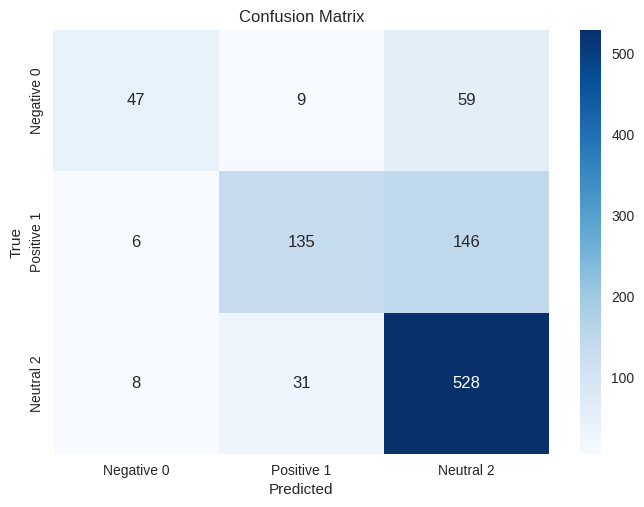

In [51]:
confusion_mat = confusion_matrix(test__lable_for_finance, predictions_for_finance_news)

sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative 0', 'Positive 1', 'Neutral 2'], yticklabels=['Negative 0', 'Positive 1', 'Neutral 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


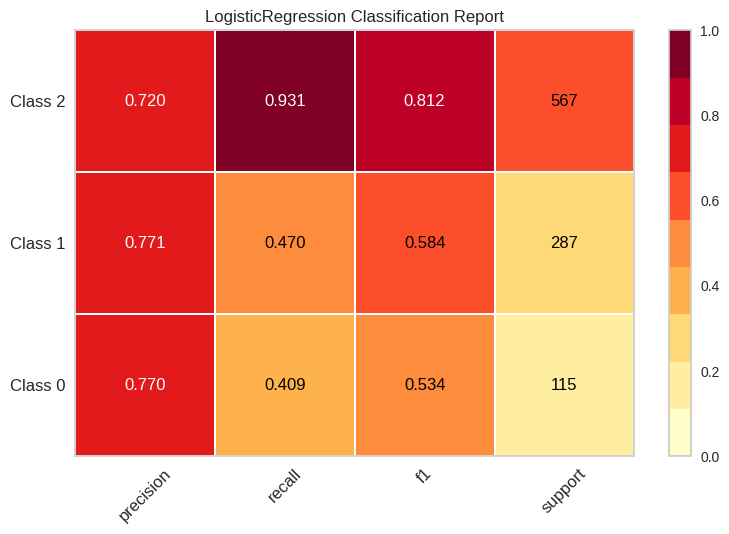

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [49]:
visualizer = ClassificationReport(model_for_finance, classes=['Negative 0', 'Positive 1', 'Neutral 2'], support=True)

# Fit the visualizer and display it
visualizer.fit(train_features_for_finance_news, train_lable_for_finance)  # Assuming train_features_for_finance_news and train_lable_for_finance are your training data
visualizer.score(test_features_for_finance_news, test__lable_for_finance)  # Assuming test_features_for_finance_news and test__lable_for_finance are your testing data
visualizer.show()

### 7.2 Twitter Sentiment News Data Visualization ###

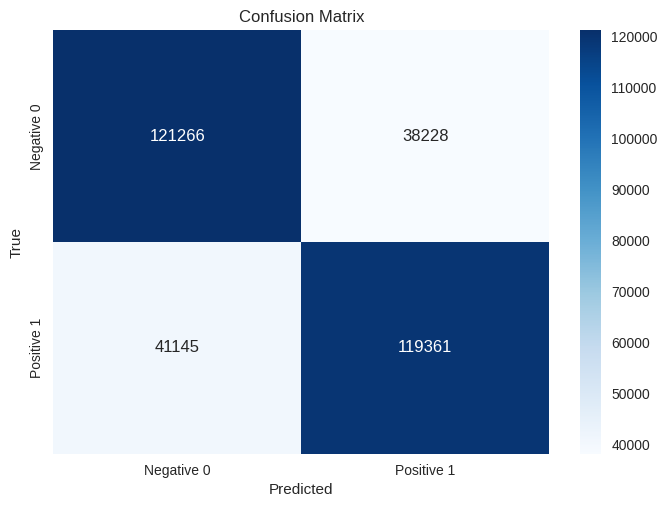

In [53]:
confusion_mat = confusion_matrix(test__lable_for_twitter_sentiment, predictions_for_twitter_sentiment)

sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative 0', 'Positive 1'], yticklabels=['Negative 0', 'Positive 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

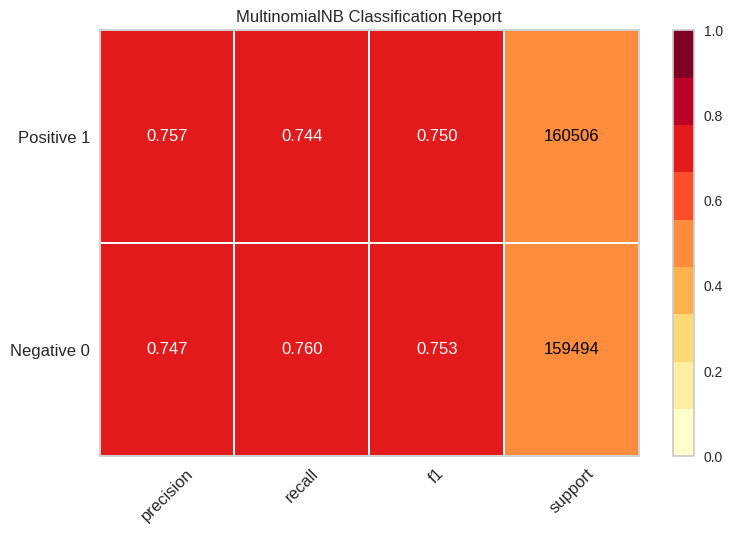

<Axes: title={'center': 'MultinomialNB Classification Report'}>

In [55]:

visualizer = ClassificationReport(model_for_twitter_sentiment, classes=['Negative 0', 'Positive 1'], support=True)

# Fit the visualizer and display it
visualizer.fit(train_features_for_twitter_sentiment, train_lable_for_twitter_sentiment)  # Assuming X_train_tfidf and y_train are your training data
visualizer.score(test_features_for_twitter_sentiment, test__lable_for_twitter_sentiment)  # Assuming X_test_tfidf and y_test are your testing data
visualizer.show()

## 8. Testing The Models

### 8.1 Testing Model For Finance ###

In [77]:
# pd.set_option('display.max_colwidth', None)
print(financial_news_df.tail(10))


      Sentiment  \
4835          0   
4836          0   
4837          0   
4838          0   
4839          0   
4840          0   
4841          2   
4842          0   
4843          0   
4844          0   

                                                                                                                                                                                                  Sentence  
4835                                                                                                                                   operating profits half 08 09 glisten invested brand management team  
4836                                                                                                    sales finland decreased 20 international sales decreased 93 terms euros 151 terms local currencies  
4837                                                                                            company said comparable operating profit januaryjune period fell short last yea

In [80]:

# Load the saved model and vectorizer
loaded_model_finance = joblib.load('./models/finacial_news_model.joblib')
loaded_vectorizer = joblib.load('./models/vectorizer.joblib')

# Example: Predict sentiment for a new financial news text
new_finance = ['sales finland decreased 105 january sales outside finland dropped 17','kwesidei whole crew']

for news in new_finance:
    
    # Transform the text using the loaded TF-IDF vectorizer
    news_tfidf = loaded_vectorizer.transform([news])

     # Predict sentiment using the loaded model
    predicted_sentiment = loaded_model_finance.predict(news_tfidf)

    print(f"Text: {news}")
    print(f"Predicted Sentiment: {predicted_sentiment[0]}")
    print("-----")

Text: sales finland decreased 105 january sales outside finland dropped 17
Predicted Sentiment: 2
-----
Text: kwesidei whole crew
Predicted Sentiment: 2
-----


### 8.2 Testing Model For Twitter Sentiment ###

In [68]:
print(twitter_sentiment_df.head(10))
print('-----------')
print(twitter_sentiment_df.tail(10))

                                                text  target
0  upset cant update facebook texting might cry r...       0
1  kenichan dived many times ball managed save 50...       0
2                   whole body feels itchy like fire       0
3           nationwideclass behaving im mad cant see       0
4                                kwesidei whole crew       0
5                                           need hug       0
6  loltrish hey long time see yes rains bit bit l...       0
7                                tatianak nope didnt       0
8                                 twittera que muera       0
9                    spring break plain city snowing       0
-----------
                                                      text  target
1599989                                   wooooo xbox back       1
1599990  rmedina latati mmmm sounds absolutely perfect ...       1
1599991                            recovering long weekend       1
1599992                                     scoob

In [67]:

# Load the saved model and vectorizer
loaded_model = joblib.load('./models/twiter_news_sentiment_model.joblib')
loaded_vectorizer = joblib.load('./models/vectorizer.joblib')

# Example: Predict sentiment for a new financial news text
new_text = ['wooooo xbox back','nationwideclass behaving im mad cant see']

for text in new_text:
    
    # Transform the text using the loaded TF-IDF vectorizer
    text_tfidf = loaded_vectorizer.transform([text])

     # Predict sentiment using the loaded model
    predicted_sentiment = loaded_model.predict(text_tfidf)

    print(f"Text: {text}")
    print(f"Predicted Sentiment: {predicted_sentiment[0]}")
    print("-----")

Text: wooooo xbox back
Predicted Sentiment: 1
-----
Text: nationwideclass behaving im mad cant see
Predicted Sentiment: 0
-----


                                                text  target
0  upset cant update facebook texting might cry r...       0
1  kenichan dived many times ball managed save 50...       0
2                   whole body feels itchy like fire       0
3           nationwideclass behaving im mad cant see       0
4                                kwesidei whole crew       0
5                                           need hug       0
6  loltrish hey long time see yes rains bit bit l...       0
7                                tatianak nope didnt       0
8                                 twittera que muera       0
9                    spring break plain city snowing       0
